# Imports

In [21]:
import datasets
import matplotlib.pyplot as plt
import tqdm
import collections
import numpy as np

# Dataset loading
First, load the HF wikitext dataset. The first run will involve a download, after which it will be cached.

In [3]:
dataset_group = 'wikitext'
dataset_name = 'wikitext-103-raw-v1'
dataset_split = 'train'
dataset_full_name = '/'.join([dataset_group, dataset_name, dataset_split])

dataset = datasets.load_dataset(dataset_group, name=dataset_name, split=dataset_split)

Found cached dataset wikitext (/home/tom/.cache/huggingface/datasets/wikitext/wikitext-103-raw-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


# Basic dataset information

In [4]:
num_records = len(dataset)
print(f'Number of records in {dataset_full_name}: {num_records}')

Number of records in wikitext/wikitext-103-raw-v1/train: 1801350


## Look at a few records

In [5]:
num_to_show = 10

for i in range(num_to_show):
    print(i, dataset[i]['text'])

0 
1  = Valkyria Chronicles III = 

2 
3  Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . 

4  The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving f

Looking at this we can see that the dataset is split at the section/subsection level, with headings occurring as separate records. From a language modelling point of view this doesn't seem ideal (earlier sections provide a lot of useful context, for instance) but let's roll with it for now. This won't be an issue for training a tokeniser, but is a useful thing to experiment with during training.

## Record length distribution

In [6]:
record_lengths = []
for record in tqdm.tqdm(dataset):
    record_lengths.append(len(record['text']))

100%|█████████████████████████████| 1801350/1801350 [00:09<00:00, 197682.99it/s]


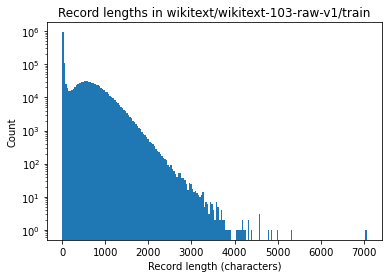

In [7]:
fig, axes = plt.subplots(1)
axes.hist(record_lengths, bins=200, log=True)
axes.set_xlabel('Record length (characters)')
axes.set_ylabel('Count')
axes.set_title(f'Record lengths in {dataset_full_name}')
plt.show()

## Number of characters & character count

In [29]:
chars = collections.defaultdict(int)  # initialises to zero
num_chars = 0

for record in tqdm.tqdm(dataset):
    for char in record['text']:
        chars[char] += 1
        num_chars += 1

100%|██████████████████████████████| 1801350/1801350 [00:46<00:00, 38540.67it/s]


In [30]:
num_unique_chars = len(chars.keys())
print(f'Number of unique characters in {dataset_full_name}: {num_unique_chars}')
print(f'Total number of characters in {dataset_full_name}: {num_chars}')

Number of unique characters in wikitext/wikitext-103-raw-v1/train: 4979
Total number of characters in wikitext/wikitext-103-raw-v1/train: 538294333


In [10]:
char_counts = [chars[k] for k in chars]

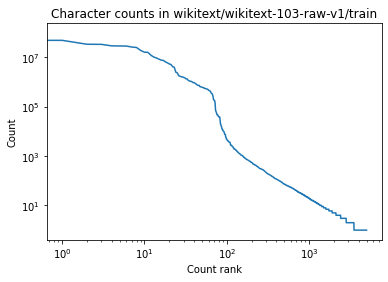

In [11]:
fig, axes = plt.subplots(1)
axes.plot(sorted(char_counts, reverse=True))
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlabel('Count rank')
axes.set_ylabel('Count')
axes.set_title(f'Character counts in {dataset_full_name}')
plt.show()

Characters clearly don't follow a Zipfian distribution overall, unlike words. Although the tail plausibly does follow a Zipf distribution, and the first ~100 characters may also do so, the parameters clearly differ between these cases and there's a sharp transition around rank 100.

## Number of words and word count

In [13]:
words = collections.defaultdict(int)
num_words = 0

for record in tqdm.tqdm(dataset):
    for word in record['text'].split(' '):
        words[word] += 1
        num_words += 1

100%|██████████████████████████████| 1801350/1801350 [00:20<00:00, 86357.27it/s]


In [16]:
print(f'Total word count in {dataset_full_name}: {num_words}')
print(f'Number of unique words in {dataset_full_name}: {len(words)}')

Total word count in wikitext/wikitext-103-raw-v1/train: 104392757
Number of unique words in wikitext/wikitext-103-raw-v1/train: 623943


In [18]:
word_counts = [words[k] for k in words]

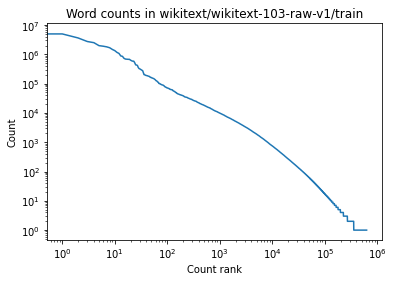

In [19]:
fig, axes = plt.subplots(1)
axes.plot(sorted(word_counts, reverse=True))
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlabel('Count rank')
axes.set_ylabel('Count')
axes.set_title(f'Word counts in {dataset_full_name}')
plt.show()

Looks like a pretty solid Zipfian distribution! How many words do we lose (in terms of words that get tokenised as `<UNK>` in the corpus) if we set the cutoff at (say) 1024 words?

Text(0.5, 1.0, 'Proportion of corpus comprised of top-k words\nin wikitext/wikitext-103-raw-v1/train')

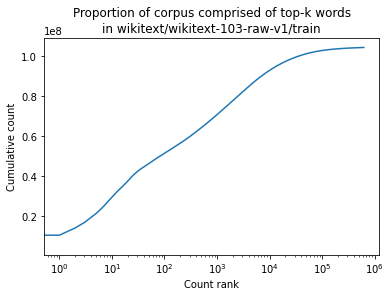

In [28]:
fig, axes = plt.subplots(1)
axes.plot(np.cumsum(sorted(word_counts, reverse=True)))
axes.set_xscale('log')
axes.set_xlabel('Count rank')
axes.set_ylabel('Cumulative count')
axes.set_title(f'Proportion of corpus comprised of top-k words\nin {dataset_full_name}')

So we'd get ~80% of words if we just used the top 1,024, and almost all if we used the top 16,384.